# *Model Interferometry* | Lab-Session #4
## Jan-20-2021 13:45

This jupyter notebook is a used to collect and analyse data during today's lab session

In [203]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import numpy.fft as fft
import matplotlib.pyplot as plt 
import scipy.constants as consts
import scipy.signal as signal
import cmath
import os
from csvlib import *
from scipy.optimize import curve_fit

# Display mpl in notebook format
%matplotlib inline

# Data Collection

In [204]:
# open CSV files to numpy array
directory = './DATA_Candle/ALL0003/'
csvs = list_csv(directory=directory,PRINT='True')       # Lists CSV files in a given directory
DATACH1 = pd.read_csv(directory+csvs[0],skiprows=19)    # Gets the CSV file as a Pandas Data Frame
channel1 = DATACH1.to_numpy().T[3:5]                    # Gets data as a numpy array

DATACH2 = pd.read_csv(directory+csvs[1],skiprows=19)    # Gets the CSV file as a Pandas Data Frame
channel2 = DATACH2.to_numpy().T[3:5]                    # Gets data as a numpy array

List of .csv files in ./DATA_Candle/ALL0003/
	 0 : F0003CH1.csv
	 1 : F0003CH2.csv


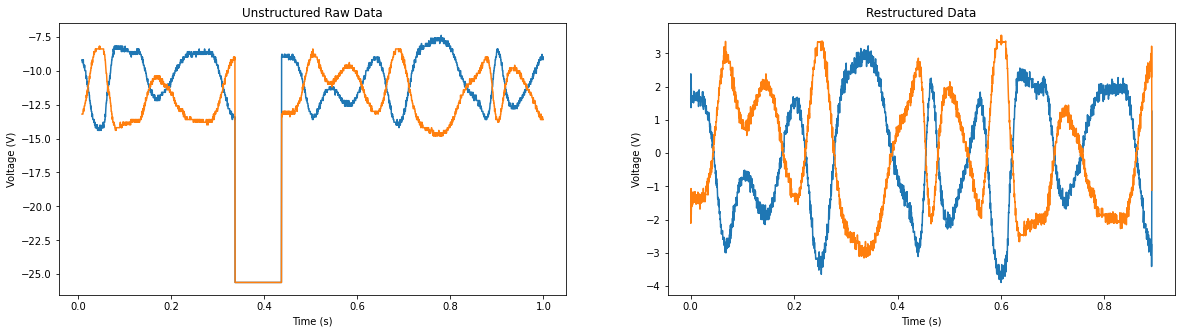

In [205]:
# Now plot the data
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('Unstructured Raw Data')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')

ax1.plot(channel1[0],channel1[1])
ax1.plot(channel2[0],channel2[1]);


# Now we want to restructure the data to get rid of that annoying gap
# First find the index where the gap starts
start = np.where(channel1[1]<=-20)[0][0]
end   = np.where(channel1[1]<=-20)[0][-1]

# Now we will take all the data before start and we will add them after the array
def restructure(array,start, end):
    return np.append(array[end+1:],array[:start],axis=0)

ch1 = [restructure(X,start,end) for X in channel1]
ch2 = [restructure(X,start,end) for X in channel2]

# We will also substract the DC peak
ch1[1] -= np.mean(ch1[1])
ch2[1] -= np.mean(ch2[1])

# Let's filter!
# Low pass Butterworth filter
def lowpass(sig,fc,fs,order=1):
    coeffs = signal.butter(order, 2*fc/fs)
    return signal.lfilter(coeffs[0],coeffs[1],signal)

# dt = np.mean(channel1[0][1:] - channel1[0][:-1])
# ch1[1] = lowpass(ch1[1],1,1/dt,order=1)

# We will also reample channel the channels to include more points
Factor = 10
N_resample = len(ch1[0])*Factor
ch1[1] = signal.resample(ch1[1],N_resample)
ch2[1] = signal.resample(ch2[1],N_resample)

# # And Finally, we will tile the array
# ch1[1] = np.tile(ch1[1],10)
# ch2[1] = np.tile(ch2[1],10)

# Now to fix the time dependance we do the following
dt = np.mean(channel1[0][1:] - channel1[0][:-1])/Factor
ch1[0] = np.linspace(0,dt*len(ch1[1]),len(ch1[1]))
ch2[0] = np.linspace(0,dt*len(ch2[1]),len(ch2[1]))

# Plot the new data
ax2.set_title('Restructured Data')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Voltage (V)')

ax2.plot(ch1[0],ch1[1])
ax2.plot(ch2[0],ch2[1]);

# Data Analysis

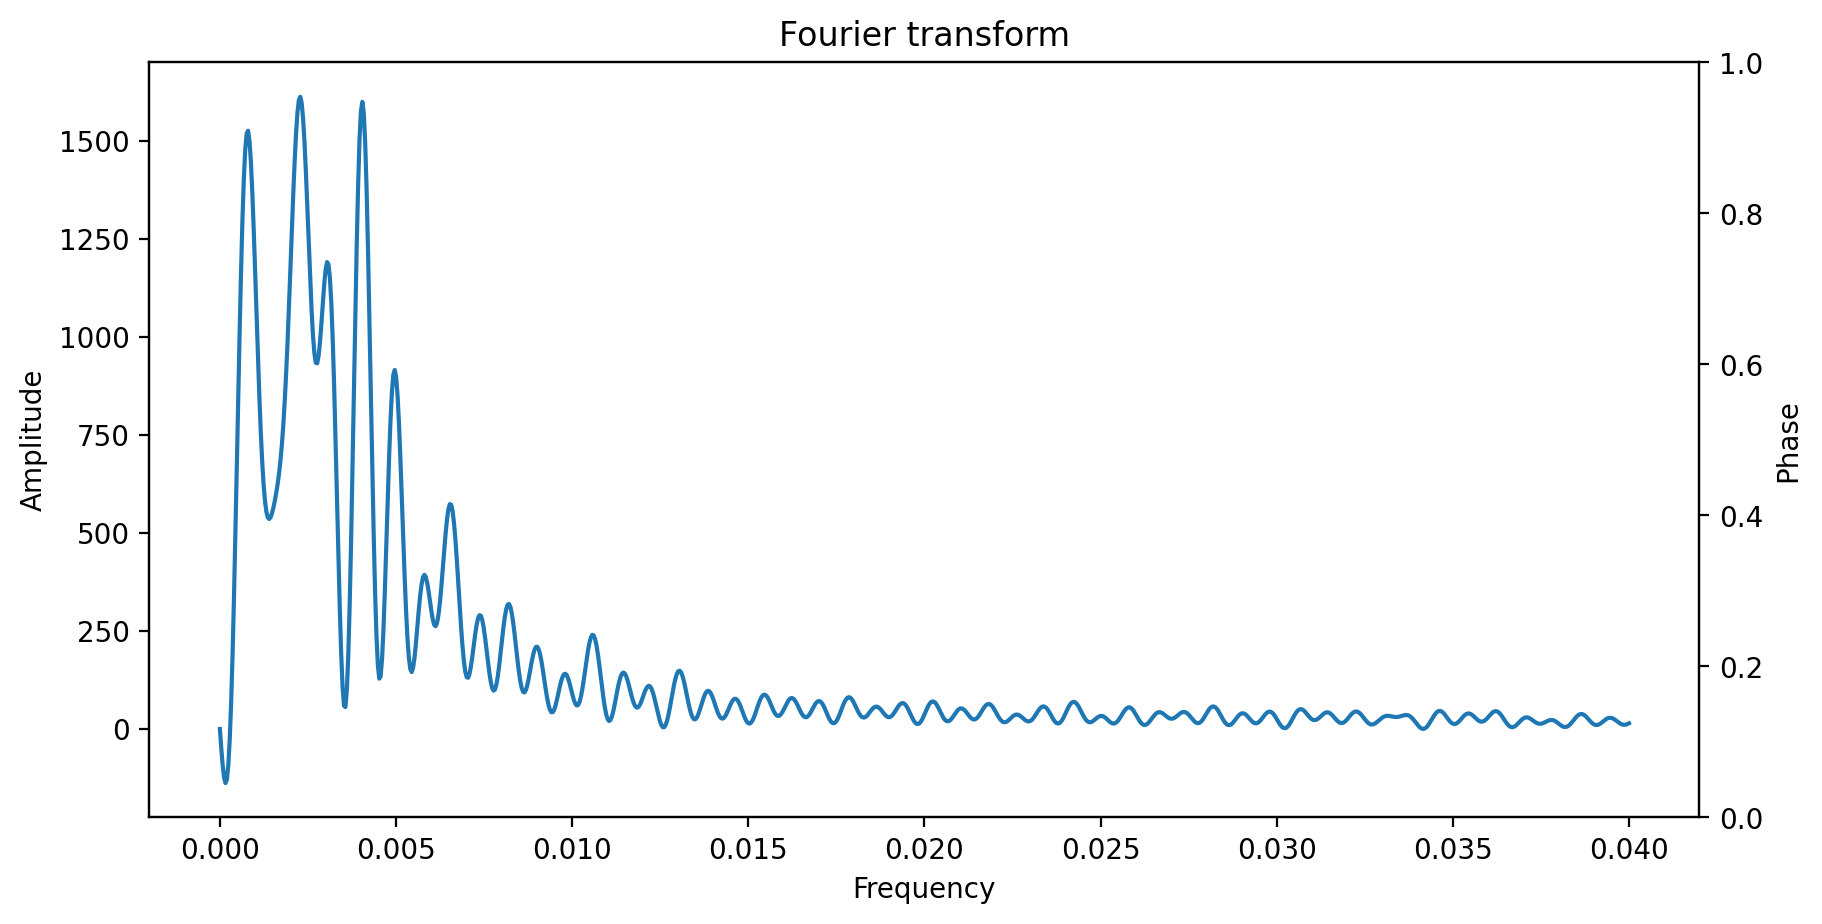

In [213]:
# Let's take the fourier transform of this data
F = fft.fft(ch1[1])
freq = fft.fftfreq(len(ch1[0]),d=dt)

f = freq[0:len(F)//2]
A = abs(F)[0:len(F)//2]
dt = np.mean(ch1[0][1:] - ch1[0][:-1])
A/=np.sum(A)*dt
phi = np.array([cmath.phase(FF) for FF in F])[0:len(F)//2]

# Now plot the transform
fig = plt.figure(figsize = (10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.set_title('Fourier transform')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Phase')

# ax1.set_xlim(0,100)

# We will also reample to include more points
Factor = 10
N_resample = len(A)*Factor
A = signal.resample(A,N_resample)

f = f[:1000]
A = A[:1000]
phi = phi[:1000]

# Now to fix the frequency dependance we do the following
dt = np.mean(f[1:] - f[:-1])/Factor
flong = np.linspace(0,dt*len(A),len(A))

ax1.plot(flong,A)
# ax2.plot(f,phi,ls='--',alpha=0.5);

<ipython-input-232-223f5944650c>:2: RuntimeWarning: invalid value encountered in double_scalars
  fit = lambda v,a,b: 4*b*np.pi *(np.pi * a)**(-3/2) *v**2 *np.exp(-v**2/a)
[7.33847472e-06 4.00789053e+00]


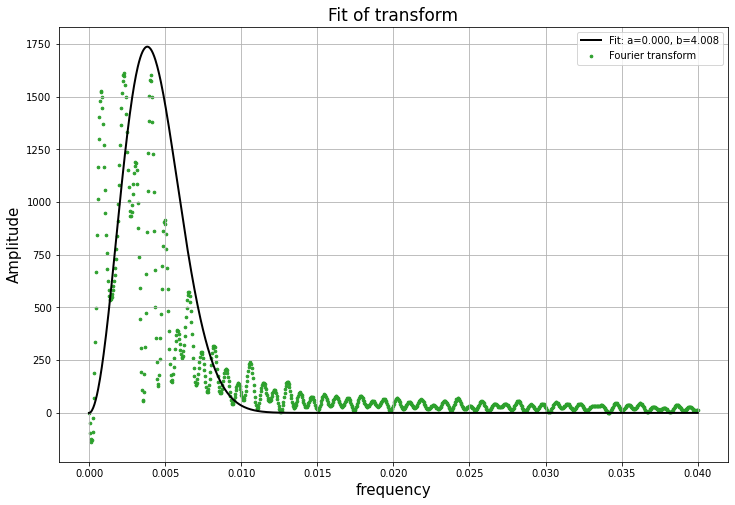

In [232]:
# Now we will fit a boltzmann distribution
fit = lambda v,a,b: 4*b*np.pi *(np.pi * a)**(-3/2) *v**2 *np.exp(-v**2/a)

params, _ = curve_fit(fit,flong,A,p0=(0.1,1))
# Define the figure and plot parameters
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Fit of transform',fontsize=17)
ax.set_xlabel('frequency',fontsize=15)
ax.set_ylabel('Amplitude',fontsize=15)

# Plot the actual elements
ax.scatter(flong,A,color = 'C2',s = 7, marker = 'o',label='Fourier transform')
ax.plot(flong,fit(flong,2*7.33847472e-06,2*4.00789053e+0), color = 'black', lw = 2, label='Fit: a=%5.3f, b=%5.3f'%tuple(params))
print(params)
ax.legend(fontsize = 10)
ax.grid()

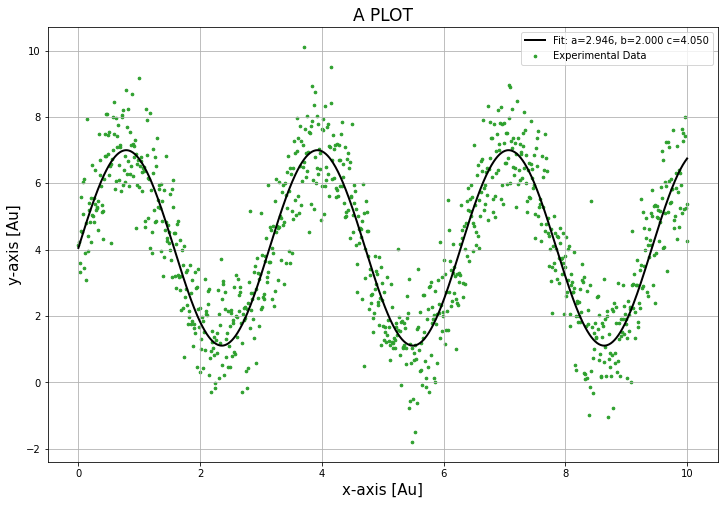

In [3]:
# Data fitting
# let's get some data x,y
Npts = 1000
x = np.linspace(0,10,Npts)
y = 3*np.sin(2*x) + 4 + np.random.normal(0,1,Npts)

# Example of trying to fit a function with 3 parameters 
def fit(x,a,b,c):
    return a*np.sin(b*x) + c

params, _ = curve_fit(fit,x,y,bounds=(0,(4,4,6)))

# Define the figure and plot parameters
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('A PLOT',fontsize=17)
ax.set_xlabel('x-axis [Au]',fontsize=15)
ax.set_ylabel('y-axis [Au]',fontsize=15)

# Plot the actual elements
ax.scatter(x,y,color = 'C2',s = 7, marker = 'o',label='Experimental Data')
ax.plot(x,fit(x,*params), color = 'black', lw = 2, label='Fit: a=%5.3f, b=%5.3f c=%5.3f'%tuple(params))

ax.legend(fontsize = 10)
ax.grid()